# Security Session Feature Analysis
This notebook performs feature analysis on `security_sessions.csv`:
- Irrelevant feature removal
- Multicollinearity analysis
- Outlier detection
- Missing value treatment
- Numerical encoding
- Scaling / normalization
- Over-sampling for imbalanced classes


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

plt.rcParams['figure.figsize'] = (6,4)


In [2]:
# Load dataset
df = pd.read_csv('./data/security_sessions.csv')
df.head()


,src_ip,dst_ip,src_port,dst_port,protocol,packet_size,duration,flag_count,bytes_sent,label
0,10.102.179.93,10.178.199.42,51081,80,TCP,620.0,7.35,3.0,3199.0,0
1,10.14.106.72,10.191.243.15,33615,3306,TCP,554.0,18.71,3.0,3728.0,0
2,10.188.20.103,10.110.156.33,29071,443,TCP,654.0,9.20,1.0,3698.0,0
3,10.121.210.215,10.243.221.231,61621,80,TCP,624.0,16.10,0.0,2703.0,0
4,10.74.202.88,10.154.163.157,35806,443,TCP,411.0,65.80,5.0,1788.0,0


In [3]:
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   src_ip       500 non-null    object 
 1   dst_ip       500 non-null    object 
 2   src_port     500 non-null    int64  
 3   dst_port     500 non-null    int64  
 4   protocol     500 non-null    object 
 5   packet_size  490 non-null    float64
 6   duration     490 non-null    float64
 7   flag_count   490 non-null    float64
 8   bytes_sent   490 non-null    float64
 9   label        500 non-null    int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 39.2+ KB


,src_ip,dst_ip,src_port,dst_port,protocol,packet_size,duration,flag_count,bytes_sent,label
count,500,500,500.000000,500.000000,500,490.000000,490.000000,490.000000,490.000000,500.000000
unique,500,500,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
top,10.133.66.135,10.116.220.154,NaN,NaN,TCP,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,306,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,31574.012000,1901.582000,NaN,639.718367,39.787367,2.853061,3028.873469,0.096000
std,NaN,NaN,19225.335767,2914.634479,NaN,435.642119,122.500962,1.718074,859.967472,0.294886
min,NaN,NaN,1121.000000,22.000000,NaN,250.000000,0.100000,0.000000,771.000000,0.000000
25%,NaN,NaN,14187.250000,80.000000,NaN,531.500000,9.212500,2.000000,2459.250000,0.000000
50%,NaN,NaN,30256.500000,443.000000,NaN,614.000000,23.255000,3.000000,3004.000000,0.000000
75%,NaN,NaN,49505.250000,3306.000000,NaN,687.750000,44.182500,4.000000,3559.500000,0.000000


## 2-1. Removing Irrelevant Features
We drop high-cardinality identifiers (`src_ip`, `dst_ip`) that tend to overfit and add little generalizable information for supervised learning.

In [4]:
irrelevant_cols = ['src_ip', 'dst_ip']
df_reduced = df.drop(columns=irrelevant_cols)
df_reduced.head()


,src_port,dst_port,protocol,packet_size,duration,flag_count,bytes_sent,label
0,51081,80,TCP,620.0,7.35,3.0,3199.0,0
1,33615,3306,TCP,554.0,18.71,3.0,3728.0,0
2,29071,443,TCP,654.0,9.20,1.0,3698.0,0
3,61621,80,TCP,624.0,16.10,0.0,2703.0,0
4,35806,443,TCP,411.0,65.80,5.0,1788.0,0


## 2-2. Handling Multicollinearity
We inspect correlation matrix, scatter plots, and compute Variance Inflation Factor (VIF).

In [5]:
numeric_cols = ['src_port','dst_port','packet_size','duration','flag_count','bytes_sent']

corr = df_reduced[numeric_cols].corr()
corr


,src_port,dst_port,packet_size,duration,flag_count,bytes_sent
src_port,1.000000,0.025598,-0.045135,0.029973,0.033642,-0.005277
dst_port,0.025598,1.000000,-0.063670,0.053153,-0.057268,-0.082869
packet_size,-0.045135,-0.063670,1.000000,-0.020142,0.027149,0.212266
duration,0.029973,0.053153,-0.020142,1.000000,-0.033564,-0.047571
flag_count,0.033642,-0.057268,0.027149,-0.033564,1.000000,-0.018387
bytes_sent,-0.005277,-0.082869,0.212266,-0.047571,-0.018387,1.000000


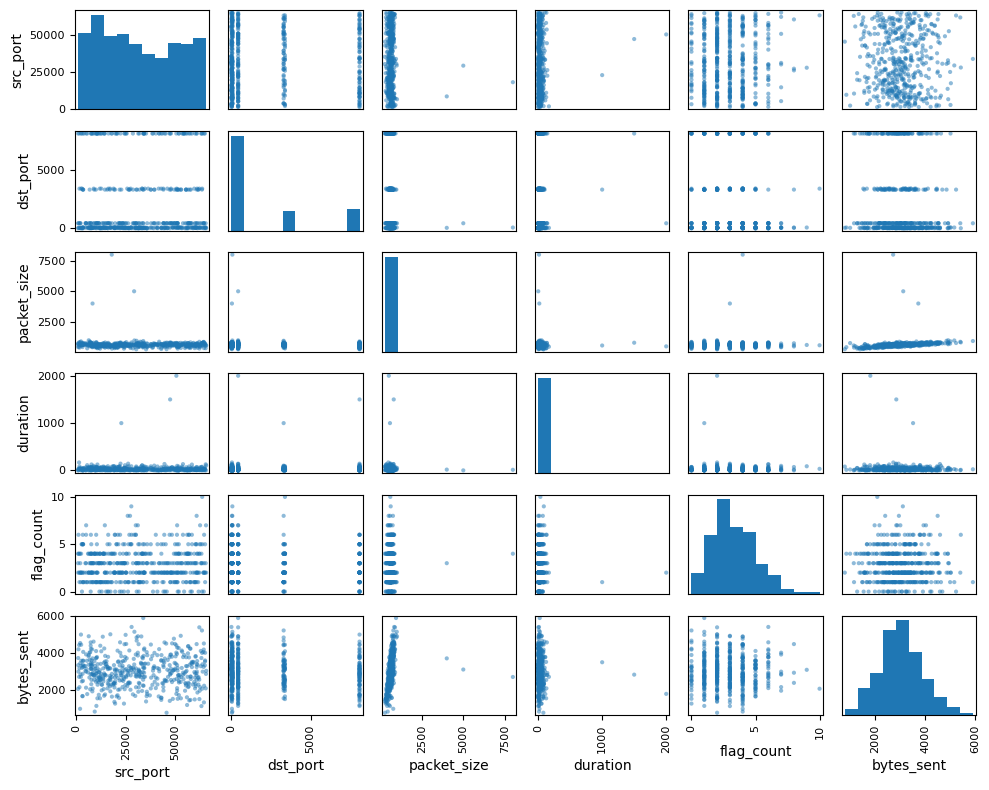

In [6]:
# Simple scatter matrix for numeric features
pd.plotting.scatter_matrix(df_reduced[numeric_cols], figsize=(10, 8))
plt.tight_layout()
plt.show()


In [7]:
# VIF computation (dropping rows with missing values)
X_vif = df_reduced[numeric_cols].dropna()
X_vif_const = sm.add_constant(X_vif)

vif_data = []
for i, col in enumerate(X_vif_const.columns):
    if col == 'const':
        continue
    vif = variance_inflation_factor(X_vif_const.values, i)
    vif_data.append((col, vif))

vif_df = pd.DataFrame(vif_data, columns=['feature','VIF'])
vif_df


,feature,VIF
0,src_port,1.008631
1,dst_port,1.015414
2,packet_size,1.062446
3,duration,1.004144
4,flag_count,1.011049
5,bytes_sent,1.066326


## 2-3. Outlier Detection (IQR and Z-score)

In [8]:
def iqr_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

for col in ['duration','packet_size']:
    s = df_reduced[col].dropna()
    lower, upper = iqr_outlier_bounds(s)
    print(f"{col}: IQR lower={lower:.2f}, upper={upper:.2f}, outliers={( (s < lower) | (s > upper) ).sum()}")


duration: IQR lower=-43.24, upper=96.64, outliers=20
packet_size: IQR lower=297.12, upper=922.12, outliers=11


In [9]:
# Z-score based outlier detection
for col in ['duration','packet_size']:
    s = df_reduced[col].dropna()
    z = np.abs(stats.zscore(s))
    outliers = (z > 3).sum()
    print(f"{col}: Z-score outliers={outliers}")


duration: Z-score outliers=3
packet_size: Z-score outliers=3


In [10]:
# Create a cleaned copy removing outliers based on IQR for duration and packet_size
clean = df_reduced.copy()
for col in ['duration','packet_size']:
    s = clean[col]
    lower, upper = iqr_outlier_bounds(s.dropna())
    mask = (s >= lower) & (s <= upper)
    clean = clean[mask | s.isna()]  # keep NaN for later missing-value treatment

clean.shape


(469, 8)

## 2-4. Treating Missing Values
We explore different strategies: column drop, row drop, and imputation.

In [11]:
clean.isna().sum()


src_port        0
dst_port        0
protocol        0
packet_size    10
duration       10
flag_count      8
bytes_sent      9
label           0
dtype: int64

In [12]:
# Example 1: drop rows with any missing values
rows_dropped = clean.dropna()
rows_dropped.shape


(432, 8)

In [13]:
# Example 2: drop columns with too many missing values (here, threshold 20%)
threshold = 0.2 * len(clean)
cols_to_drop = [c for c in clean.columns if clean[c].isna().sum() > threshold]
cols_to_drop


[]

In [14]:
# Example 3: Impute numeric columns with 0
imputed_zero = clean.copy()
num_cols = ['packet_size','duration','flag_count','bytes_sent']
imputed_zero[num_cols] = imputed_zero[num_cols].fillna(0)
imputed_zero[num_cols].isna().sum()


packet_size    0
duration       0
flag_count     0
bytes_sent     0
dtype: int64

In [15]:
# Example 4: Forward-fill then back-fill (useful for time-ordered logs)
ffill_bfill = clean.sort_index().copy()
ffill_bfill[num_cols] = ffill_bfill[num_cols].fillna(method='ffill').fillna(method='bfill')
ffill_bfill[num_cols].isna().sum()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_102920\919886675.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ffill_bfill[num_cols] = ffill_bfill[num_cols].fillna(method='ffill').fillna(method='bfill')


packet_size    0
duration       0
flag_count     0
bytes_sent     0
dtype: int64

## 2-5. Numerical Encoding
We encode the categorical `protocol` feature and briefly demonstrate text embedding.

In [16]:
# One-hot encode 'protocol'
protocol_encoded = pd.get_dummies(ffill_bfill['protocol'], prefix='proto')
encoded_df = pd.concat([ffill_bfill.drop(columns=['protocol']), protocol_encoded], axis=1)
encoded_df.head()


,src_port,dst_port,packet_size,duration,flag_count,bytes_sent,label,proto_ICMP,proto_TCP,proto_UDP
0,51081,80,620.0,7.35,3.0,3199.0,0,False,True,False
1,33615,3306,554.0,18.71,3.0,3728.0,0,False,True,False
2,29071,443,654.0,9.20,1.0,3698.0,0,False,True,False
3,61621,80,624.0,16.10,0.0,2703.0,0,False,True,False
4,35806,443,411.0,65.80,5.0,1788.0,0,False,True,False


In [17]:
# Ordinal encoding example (treating dst_port as ordinal binned feature)
bins = [0, 1024, 10000, 65535]
labels_ = [0, 1, 2]
encoded_df['dst_port_band'] = pd.cut(encoded_df['dst_port'], bins=bins, labels=labels_)
encoded_df[['dst_port','dst_port_band']].head()


,dst_port,dst_port_band
0,80,0
1,3306,1
2,443,0
3,80,0
4,443,0


In [18]:
# Simple text embedding example using synthetic text column
from sklearn.feature_extraction.text import TfidfVectorizer

sample_text = pd.Series([
    'ssh brute force attack',
    'normal web browsing',
    'dns amplification attack',
    'port scan detected'
], name='payload')

vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(sample_text)
pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())


,amplification,attack,browsing,brute,detected,dns,force,normal,port,scan,ssh,web
0,0.000000,0.414289,0.00000,0.525473,0.00000,0.000000,0.525473,0.00000,0.00000,0.00000,0.525473,0.00000
1,0.000000,0.000000,0.57735,0.000000,0.00000,0.000000,0.000000,0.57735,0.00000,0.00000,0.000000,0.57735
2,0.617614,0.486934,0.00000,0.000000,0.00000,0.617614,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000
3,0.000000,0.000000,0.00000,0.000000,0.57735,0.000000,0.000000,0.00000,0.57735,0.57735,0.000000,0.00000


## 2-6. Scaling / Normalization

In [19]:
feature_cols = ['src_port','dst_port','packet_size','duration','flag_count','bytes_sent']
X = encoded_df[feature_cols]
y = encoded_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standard scaling
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

# Min-max scaling
mm_scaler = MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

X_train_std[:3], X_train_mm[:3]


(array([[-0.88615915,  2.14299618, -0.50395131,  0.05586234, -0.47118826,
         -0.25080317],
        [-1.17513552,  0.52336792,  0.03440952,  1.70023417,  0.12575633,
          0.10929704],
        [-0.49696066, -0.62842912, -0.62358705, -1.03286114, -1.06813285,
         -1.19501243]]),
 array([[0.20856564, 1.        , 0.4303351 , 0.31216701, 0.2       ,
         0.39362939],
        [0.12194362, 0.41784562, 0.54144621, 0.72404045, 0.3       ,
         0.46314811],
        [0.32522971, 0.00384711, 0.40564374, 0.03946939, 0.1       ,
         0.2113462 ]]))

## 2-7. Over-sampling
We use RandomOverSampler to balance the binary labels (normal vs attack).

In [20]:
# Check original class distribution
print('Original class distribution:')
print(y_train.value_counts())

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print('\nAfter RandomOverSampler:')
print(y_resampled.value_counts())


Original class distribution:
label
0    338
1     37
Name: count, dtype: int64

After RandomOverSampler:
label
0    338
1    338
Name: count, dtype: int64
